# GSM8K CoT Attribution Heatmap Sequence Analysis

This notebook generates **sequential attribution graphs** for each token in a Chain-of-Thought (CoT) response to a GSM8K math problem. We then visualize how token influence evolves across the reasoning sequence.

## Objectives
1. Generate one attribution graph per generated token in the CoT sequence
2. Create heatmap visualizations showing layer×position influence for each token
3. Analyze how computational patterns change across reasoning steps

---
## Setup: Install Dependencies and Configure Environment

In [1]:
  # Step 1: Install base dependencies
  print("Installing base dependencies...")
  !pip install -q huggingface_hub transformers accelerate einops torch matplotlib seaborn tqdm numpy

  # Step 2: Upload circuit-tracer.zip
  print("\Please upload your circuit-tracer.zip file:")
  from google.colab import files
  import zipfile

  uploaded = files.upload()

  # Step 3: Extract and install circuit-tracer
  print("\nExtracting circuit-tracer...")
  with zipfile.ZipFile('circuit-tracer.zip', 'r') as zip_ref:
      zip_ref.extractall('.')

  print("Installing circuit-tracer...")
  !pip install -q ./circuit-tracer

  # Step 4: Update transformers (fixes BertForPreTraining error)
  print("Updating transformers...")
  !pip install --upgrade transformers accelerate -q

  # Step 5: Verify installation
  print("\n" + "="*60)
  print("VERIFICATION")
  print("="*60)

  import warnings
  warnings.filterwarnings('ignore')

  try:
      import torch
      from circuit_tracer import attribute, ReplacementModel
      from circuit_tracer.graph import Graph, compute_node_influence

      print("✅ All packages installed successfully!")
      print(f"   PyTorch: {torch.__version__}")
      print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

  except ImportError as e:
      print(f"❌ Import failed: {e}")
      print("\n⚠️  ACTION REQUIRED:")
      print("   1. Runtime → Restart runtime")
      print("   2. Run all cells again")
      raise

  print("\n" + "="*60)
  print("⚠️  IMPORTANT: Restart runtime now!")
  print("="*60)
  print("1. Go to: Runtime → Restart runtime")
  print("2. Then run cells starting from 'HuggingFace Login' cell")
  print("3. Skip this installation cell (already done)")
  print("="*60)


Installing base dependencies...

📁 Please upload your circuit-tracer.zip file:


Saving circuit-tracer.zip to circuit-tracer.zip

Extracting circuit-tracer...
Installing circuit-tracer...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.8 MB/s eta 0:00:

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [1]:
# Configure environment
import os

# Set cache directory (adjust for Colab)
cache_dir = "/content/huggingface_cache"  # Colab path
os.environ['HF_HOME'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

print(f"✅ Hugging Face cache directory: {os.environ['HF_HOME']}")

✅ Hugging Face cache directory: /content/huggingface_cache


In [2]:
# HuggingFace login (required for Gemma access)
from huggingface_hub import login

# Option 1: Use notebook_login for interactive token entry
login()

# Option 2: Or set token directly (not recommended for shared notebooks)
# login(token="your_token_here")

---
## Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm

from circuit_tracer import attribute, ReplacementModel
from circuit_tracer.graph import Graph, compute_node_influence

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ All imports successful")

✅ All imports successful


---
## Load Model with Transcoder

In [4]:
# Load Gemma-2-2b with Gemma Scope transcoders
model_name = 'google/gemma-2-2b'
transcoder_name = "gemma"

print(f"Loading {model_name} with transcoder '{transcoder_name}'...")
model = ReplacementModel.from_pretrained(
    model_name,
    transcoder_name,
    dtype=torch.bfloat16
)

print(f"✅ Model loaded successfully")
print(f"   Device: {model.cfg.device}")
print(f"   Layers: {model.cfg.n_layers}")
print(f"   d_model: {model.cfg.d_model}")

Loading google/gemma-2-2b with transcoder 'gemma'...


config.yaml: 0.00B [00:00, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

layer_6/width_16k/average_l0_95/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_7/width_16k/average_l0_70/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_5/width_16k/average_l0_87/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_0/width_16k/average_l0_76/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_2/width_16k/average_l0_49/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_3/width_16k/average_l0_54/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_4/width_16k/average_l0_88/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_1/width_16k/average_l0_65/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_8/width_16k/average_l0_52/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_9/width_16k/average_l0_72/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_10/width_16k/average_l0_88/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_11/width_16k/average_l0_5/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_12/width_16k/average_l0_6/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_13/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_14/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_15/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_16/width_16k/average_l0_10/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_17/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_18/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_19/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_20/width_16k/average_l0_11/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_22/width_16k/average_l0_15/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_21/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_23/width_16k/average_l0_25/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_24/width_16k/average_l0_37/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_25/width_16k/average_l0_41/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer
✅ Model loaded successfully
   Device: cuda
   Layers: 26
   d_model: 2304


---
## Define GSM8K Prompt and CoT Response

In [13]:
base_prompt = "Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?"
prompt = base_prompt + " Explain step by step."

print("="*60)
print("PROMPT:")
print("="*60)
print(prompt)
print("\n" + "="*60)
print("GENERATING CoT RESPONSE (until natural stop)...")
print("="*60)

# Tokenize
input_ids = model.tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.cfg.device)

# Generate with natural stopping
output = model.generate(
    input_ids,
    max_new_tokens=200,      # Safety limit (won't hit if EOS comes first)
    stop_at_eos=True,        # Stop when model outputs EOS token
    eos_token_id=model.tokenizer.eos_token_id,
    do_sample=False          # Greedy decoding
)

# Extract generated text
generated_ids = output[0][len(input_ids[0]):]
cot_response = model.tokenizer.decode(generated_ids, skip_special_tokens=True)

print("\n" + "="*60)
print(f"GENERATED CoT ({len(generated_ids)} tokens):")
print("="*60)
print(cot_response)
print("="*60)

print(f"\nPrompt tokens: {len(input_ids[0])}")
print(f"Generated tokens: {len(generated_ids)}")
print(f"Model stopped naturally: {generated_ids[-1].item() == model.tokenizer.eos_token_id}")

PROMPT:
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? Explain step by step.

GENERATING CoT RESPONSE (until natural stop)...


  0%|          | 0/200 [00:00<?, ?it/s]


GENERATED CoT (57 tokens):


Step 1
1 of 2

$\begin{align*} \text{Weng earned }&=12\times50\\ &=600 \end{align*} $

Result
2 of 2

Weng earned $\$600$

Prompt tokens: 37
Generated tokens: 57
Model stopped naturally: True


---
## Class 1: AutoregressiveCoTAnalyzer

Generates one attribution graph for each token in the CoT sequence.

In [14]:
class AutoregressiveCoTAnalyzer:
    """Generate attribution graphs for each token in a CoT sequence"""

    def __init__(self, model: ReplacementModel):
        self.model = model
        self.tokenizer = model.tokenizer

    def generate_sequential_graphs(
        self,
        prompt: str,
        cot_response: str,
        max_n_logits: int = 10,
        desired_logit_prob: float = 0.95,
        max_feature_nodes: int = 2048,
        batch_size: int = 512,
        offload: str = None,  # "cpu" or "disk" for memory savings
        verbose: bool = True
    ) -> List[Dict]:
        """
        Generate attribution graph for each token in the CoT sequence.

        Args:
            prompt: The initial question/problem
            cot_response: The step-by-step reasoning response
            max_n_logits: Max logit nodes per graph
            desired_logit_prob: Cumulative probability threshold for logits
            max_feature_nodes: Max feature nodes to include (reduce if OOM)
            batch_size: Batch size for attribution computation
            offload: "cpu" or "disk" to save GPU memory
            verbose: Print progress updates

        Returns:
            List of dicts containing:
                - token_idx: absolute position in sequence
                - relative_idx: position in generated sequence (0-indexed)
                - token: the actual token string
                - full_text: prompt + tokens up to this point
                - graph: attribution graph for this token
                - n_input_tokens: number of tokens in context
        """
        # Tokenize the full sequence
        full_text = prompt + cot_response
        full_tokens = self.tokenizer.encode(full_text, add_special_tokens=True)
        prompt_tokens = self.tokenizer.encode(prompt, add_special_tokens=True)

        n_prompt_tokens = len(prompt_tokens)
        n_total_tokens = len(full_tokens)
        n_generated_tokens = n_total_tokens - n_prompt_tokens

        print(f"\n{'='*60}")
        print(f"SEQUENCE ANALYSIS")
        print(f"{'='*60}")
        print(f"Prompt tokens: {n_prompt_tokens}")
        print(f"Generated tokens: {n_generated_tokens}")
        print(f"Total tokens: {n_total_tokens}")
        print(f"\nGenerating {n_generated_tokens} attribution graphs...")
        print(f"{'='*60}\n")

        graphs_data = []

        # For each position in the generated sequence
        for i in tqdm(range(n_prompt_tokens, n_total_tokens), desc="Generating graphs"):
            # Text up to (and including) this token
            tokens_up_to_here = full_tokens[:i+1]
            text_up_to_here = self.tokenizer.decode(tokens_up_to_here)

            # Current token being attributed
            current_token = self.tokenizer.decode([full_tokens[i]])

            if verbose and (i - n_prompt_tokens) % 10 == 0:
                print(f"\n--- Token {i - n_prompt_tokens + 1}/{n_generated_tokens} ---")
                print(f"Token: '{current_token}'")
                print(f"Context length: {len(tokens_up_to_here)} tokens")

            # Generate attribution graph for this token
            try:
                graph = attribute(
                    prompt=text_up_to_here,
                    model=self.model,
                    max_n_logits=max_n_logits,
                    desired_logit_prob=desired_logit_prob,
                    batch_size=batch_size,
                    max_feature_nodes=max_feature_nodes,
                    offload=offload,
                    verbose=False  # Suppress per-graph verbosity
                )

                graphs_data.append({
                    'token_idx': i,
                    'relative_idx': i - n_prompt_tokens,
                    'token': current_token,
                    'full_text': text_up_to_here,
                    'graph': graph,
                    'n_input_tokens': len(tokens_up_to_here)
                })
            except Exception as e:
                print(f"\n⚠ Error generating graph for token {i - n_prompt_tokens}: {e}")
                continue

        print(f"\n✓ Successfully generated {len(graphs_data)} attribution graphs")
        return graphs_data

print("✅ AutoregressiveCoTAnalyzer class defined")

✅ AutoregressiveCoTAnalyzer class defined


---
## Class 2: SequenceHeatmapGenerator

Extracts influence matrices and generates heatmaps from attribution graphs.

In [15]:
class SequenceHeatmapGenerator:
    """Generate heatmaps showing token influence across a CoT sequence"""

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def extract_influence_matrix(self, graph: Graph) -> np.ndarray:
        """
        Extract influence matrix [layer x position] from graph.

        Args:
            graph: Attribution graph from circuit-tracer

        Returns:
            Numpy array of shape (n_layers, n_positions) with cumulative influence
        """
        n_layers = graph.cfg.n_layers
        n_pos = len(graph.input_tokens)
        n_logits = len(graph.logit_tokens)
        n_features = len(graph.selected_features)

        # Compute node influences
        logit_weights = torch.zeros(graph.adjacency_matrix.shape[0])
        logit_weights[-n_logits:] = graph.logit_probabilities

        node_influence = compute_node_influence(graph.adjacency_matrix, logit_weights)

        # Initialize influence matrix
        influence_matrix = np.zeros((n_layers, n_pos))

        # Extract feature influences by layer and position
        for feat_idx in range(n_features):
            layer, pos, _ = graph.active_features[graph.selected_features[feat_idx]].tolist()
            influence = abs(node_influence[feat_idx].item())

            if 0 <= pos < n_pos and 0 <= layer < n_layers:
                influence_matrix[layer, pos] += influence

        # Add token embedding influences (critical for early layers)
        error_end_idx = n_features + n_layers * n_pos
        token_start_idx = error_end_idx
        token_end_idx = token_start_idx + n_pos

        for pos in range(n_pos):
            if token_start_idx + pos < len(node_influence):
                token_influence = abs(node_influence[token_start_idx + pos].item())
                influence_matrix[0, pos] += token_influence  # Assign to layer 0

        return influence_matrix

    def generate_heatmap_sequence(
        self,
        graphs_data: List[Dict],
        output_dir: str = './heatmaps',
        save_individual: bool = True,
        figsize: tuple = (14, 8)
    ) -> List[Dict]:
        """
        Generate heatmap for each graph in the sequence.

        Args:
            graphs_data: List of dicts from AutoregressiveCoTAnalyzer
            output_dir: Directory to save heatmaps
            save_individual: Whether to save individual heatmap files
            figsize: Figure size for each heatmap

        Returns:
            List of dicts with heatmap data and figures
        """
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True)

        heatmaps = []

        print(f"\nGenerating {len(graphs_data)} heatmaps...")

        for data in tqdm(graphs_data, desc="Creating heatmaps"):
            graph = data['graph']
            token = data['token']
            relative_idx = data['relative_idx']

            # Extract influence matrix
            influence_matrix = self.extract_influence_matrix(graph)

            # Get token labels (truncate if too long)
            token_labels = [self.tokenizer.decode([t]) for t in graph.input_tokens]

            # Create heatmap
            fig, ax = plt.subplots(figsize=figsize)

            sns.heatmap(
                influence_matrix,
                cmap='YlOrRd',
                xticklabels=token_labels,
                yticklabels=range(influence_matrix.shape[0]),
                cbar_kws={'label': 'Cumulative Influence'},
                ax=ax
            )

            ax.set_xlabel('Token Position', fontsize=12)
            ax.set_ylabel('Layer', fontsize=12)
            ax.set_title(
                f'Token {relative_idx + 1}: "{token}"\n'
                f'Attribution Influence on Output',
                fontsize=14
            )

            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

            # Save individual heatmap
            if save_individual:
                # Sanitize filename
                safe_token = token.replace('/', '_').replace('\\', '_').strip()
                filename = f"heatmap_{relative_idx:03d}_{safe_token[:20]}.png"
                filepath = output_dir / filename
                plt.savefig(filepath, dpi=150, bbox_inches='tight')

            # Store for later analysis
            heatmaps.append({
                'token_idx': relative_idx,
                'token': token,
                'influence_matrix': influence_matrix,
                'figure': fig
            })

            plt.close(fig)  # Free memory

        print(f"\n✓ Generated {len(heatmaps)} heatmaps in {output_dir}")
        return heatmaps

print("✅ SequenceHeatmapGenerator class defined")

✅ SequenceHeatmapGenerator class defined


---
## Class 3: CoTHeatmapAnalyzer

Analyzes heatmap sequences and creates aggregate visualizations.

In [16]:
class CoTHeatmapAnalyzer:
    """Analyze and visualize heatmap sequences"""

    @staticmethod
    def plot_average_influence_over_time(heatmaps: List[Dict], save_path=None):
        """Plot how average token influence changes across the sequence"""

        avg_influences = []
        tokens = []

        for hm in heatmaps:
            avg_influence = hm['influence_matrix'].mean()
            avg_influences.append(avg_influence)
            tokens.append(hm['token'])

        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(avg_influences, marker='o', linewidth=2, markersize=6, color='#e74c3c')
        ax.set_xlabel('Token Position in CoT', fontsize=12)
        ax.set_ylabel('Average Influence', fontsize=12)
        ax.set_title('Average Token Influence Across CoT Sequence', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Annotate every Nth token
        annotation_step = max(1, len(tokens) // 10)
        for i in range(0, len(tokens), annotation_step):
            ax.annotate(
                tokens[i][:10],  # Truncate long tokens
                (i, avg_influences[i]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=8,
                rotation=45
            )

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")

        plt.show()

    @staticmethod
    def plot_layer_influence_evolution(heatmaps: List[Dict], save_path=None):
        """Plot how each layer's influence evolves across tokens"""

        n_layers = heatmaps[0]['influence_matrix'].shape[0]
        layer_influences = {layer: [] for layer in range(n_layers)}

        for hm in heatmaps:
            for layer in range(n_layers):
                layer_influences[layer].append(hm['influence_matrix'][layer].sum())

        fig, ax = plt.subplots(figsize=(16, 8))

        # Use colormap for layers
        colors = plt.cm.viridis(np.linspace(0, 1, n_layers))

        for layer in range(n_layers):
            ax.plot(
                layer_influences[layer],
                label=f'Layer {layer}',
                alpha=0.7,
                color=colors[layer],
                linewidth=1.5
            )

        ax.set_xlabel('Token Position in CoT', fontsize=12)
        ax.set_ylabel('Total Layer Influence', fontsize=12)
        ax.set_title('Layer Influence Evolution Across CoT Sequence', fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")

        plt.show()

    @staticmethod
    def create_heatmap_grid(heatmaps: List[Dict], sample_every=5, save_path=None):
        """Create grid showing sample of heatmaps side-by-side"""

        sampled = heatmaps[::sample_every]
        n_samples = len(sampled)

        ncols = min(3, n_samples)
        nrows = (n_samples + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for idx, (ax, hm) in enumerate(zip(axes, sampled)):
            sns.heatmap(
                hm['influence_matrix'],
                cmap='YlOrRd',
                ax=ax,
                cbar=True,
                xticklabels=False,
                yticklabels=10
            )
            ax.set_title(f"Token {hm['token_idx']}: '{hm['token'][:15]}'...", fontsize=10)
            ax.set_xlabel('Position', fontsize=8)
            ax.set_ylabel('Layer', fontsize=8)

        # Hide unused axes
        for ax in axes[len(sampled):]:
            ax.axis('off')

        plt.suptitle('CoT Heatmap Sequence (Sampled)', fontsize=16, fontweight='bold', y=1.00)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")

        plt.show()

    @staticmethod
    def generate_summary_statistics(heatmaps: List[Dict]) -> Dict:
        """Compute summary statistics across the heatmap sequence"""

        stats = {
            'n_tokens': len(heatmaps),
            'avg_influence_per_token': [],
            'max_influence_per_token': [],
            'most_influential_layer_per_token': [],
        }

        for hm in heatmaps:
            matrix = hm['influence_matrix']
            stats['avg_influence_per_token'].append(matrix.mean())
            stats['max_influence_per_token'].append(matrix.max())
            stats['most_influential_layer_per_token'].append(matrix.sum(axis=1).argmax())

        stats['overall_avg_influence'] = np.mean(stats['avg_influence_per_token'])
        stats['overall_max_influence'] = np.max(stats['max_influence_per_token'])

        return stats

print("✅ CoTHeatmapAnalyzer class defined")

✅ CoTHeatmapAnalyzer class defined


---
## Step 1: Generate Sequential Attribution Graphs


**Memory-saving tips**:
- Set `max_feature_nodes` to be lower for compute save
- Set `offload="cpu"` to use CPU offloading
- Process fewer tokens by truncating `cot_response`

In [18]:
# Initialize analyzer
analyzer = AutoregressiveCoTAnalyzer(model)

# Generate graphs for each token
# Adjust parameters based on your resources:
graphs_data = analyzer.generate_sequential_graphs(
    prompt=prompt,
    cot_response=cot_response,
    max_feature_nodes=2048,  # REDUCE IF OOM
    batch_size=512,
    offload="cpu",  # Set to "cpu" if running out of GPU memory
    verbose=True
)

print(f"\n✅ Generated {len(graphs_data)} attribution graphs")


SEQUENCE ANALYSIS
Prompt tokens: 37
Generated tokens: 56
Total tokens: 93

Generating 56 attribution graphs...



Generating graphs:   0%|          | 0/56 [00:00<?, ?it/s]


--- Token 1/56 ---
Token: '

'
Context length: 38 tokens


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
Generating graphs:  18%|█▊        | 10/56 [02:13<10:27, 13.65s/it]


--- Token 11/56 ---
Token: '$\'
Context length: 48 tokens


Generating graphs:  36%|███▌      | 20/56 [04:38<08:51, 14.76s/it]


--- Token 21/56 ---
Token: ' earned'
Context length: 58 tokens


Generating graphs:  38%|███▊      | 21/56 [04:49<07:57, 13.65s/it]


⚠ Error generating graph for token 20: CUDA out of memory. Tried to allocate 14.82 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 10.48 GiB is allocated by PyTorch, and 13.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  39%|███▉      | 22/56 [05:00<07:18, 12.89s/it]


⚠ Error generating graph for token 21: CUDA out of memory. Tried to allocate 15.09 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 10.65 GiB is allocated by PyTorch, and 13.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  41%|████      | 23/56 [05:11<06:47, 12.35s/it]


⚠ Error generating graph for token 22: CUDA out of memory. Tried to allocate 15.25 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 10.82 GiB is allocated by PyTorch, and 13.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  43%|████▎     | 24/56 [05:23<06:23, 11.99s/it]


⚠ Error generating graph for token 23: CUDA out of memory. Tried to allocate 15.39 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 10.99 GiB is allocated by PyTorch, and 13.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  45%|████▍     | 25/56 [05:34<06:04, 11.75s/it]


⚠ Error generating graph for token 24: CUDA out of memory. Tried to allocate 15.57 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 11.16 GiB is allocated by PyTorch, and 13.06 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  46%|████▋     | 26/56 [05:45<05:47, 11.59s/it]


⚠ Error generating graph for token 25: CUDA out of memory. Tried to allocate 15.69 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 11.32 GiB is allocated by PyTorch, and 12.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  48%|████▊     | 27/56 [05:56<05:32, 11.48s/it]


⚠ Error generating graph for token 26: CUDA out of memory. Tried to allocate 15.84 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 11.49 GiB is allocated by PyTorch, and 12.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  50%|█████     | 28/56 [06:08<05:19, 11.42s/it]


⚠ Error generating graph for token 27: CUDA out of memory. Tried to allocate 16.03 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 11.66 GiB is allocated by PyTorch, and 12.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  52%|█████▏    | 29/56 [06:19<05:07, 11.39s/it]


⚠ Error generating graph for token 28: CUDA out of memory. Tried to allocate 16.24 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 11.83 GiB is allocated by PyTorch, and 12.39 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  54%|█████▎    | 30/56 [06:30<04:56, 11.39s/it]


⚠ Error generating graph for token 29: CUDA out of memory. Tried to allocate 16.41 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.00 GiB is allocated by PyTorch, and 12.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Token 31/56 ---
Token: ' &='
Context length: 68 tokens


Generating graphs:  55%|█████▌    | 31/56 [06:42<04:45, 11.40s/it]


⚠ Error generating graph for token 30: CUDA out of memory. Tried to allocate 16.60 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.18 GiB is allocated by PyTorch, and 12.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  57%|█████▋    | 32/56 [06:53<04:34, 11.42s/it]


⚠ Error generating graph for token 31: CUDA out of memory. Tried to allocate 16.73 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.35 GiB is allocated by PyTorch, and 11.88 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  59%|█████▉    | 33/56 [07:05<04:23, 11.44s/it]


⚠ Error generating graph for token 32: CUDA out of memory. Tried to allocate 16.85 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.52 GiB is allocated by PyTorch, and 11.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  61%|██████    | 34/56 [07:16<04:12, 11.46s/it]


⚠ Error generating graph for token 33: CUDA out of memory. Tried to allocate 16.97 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.69 GiB is allocated by PyTorch, and 11.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  62%|██████▎   | 35/56 [07:28<04:01, 11.49s/it]


⚠ Error generating graph for token 34: CUDA out of memory. Tried to allocate 17.11 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 12.86 GiB is allocated by PyTorch, and 11.36 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  64%|██████▍   | 36/56 [07:39<03:50, 11.51s/it]


⚠ Error generating graph for token 35: CUDA out of memory. Tried to allocate 17.22 GiB. GPU 0 has a total capacity of 39.56 GiB of which 14.82 GiB is free. Process 40118 has 24.73 GiB memory in use. Of the allocated memory 13.03 GiB is allocated by PyTorch, and 11.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  66%|██████▌   | 37/56 [07:50<03:35, 11.35s/it]


⚠ Error generating graph for token 36: CUDA out of memory. Tried to allocate 14.61 GiB. GPU 0 has a total capacity of 39.56 GiB of which 13.50 GiB is free. Process 40118 has 26.05 GiB memory in use. Of the allocated memory 13.21 GiB is allocated by PyTorch, and 12.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  68%|██████▊   | 38/56 [08:01<03:22, 11.26s/it]


⚠ Error generating graph for token 37: CUDA out of memory. Tried to allocate 14.79 GiB. GPU 0 has a total capacity of 39.56 GiB of which 13.50 GiB is free. Process 40118 has 26.05 GiB memory in use. Of the allocated memory 13.39 GiB is allocated by PyTorch, and 12.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  70%|██████▉   | 39/56 [08:12<03:10, 11.20s/it]


⚠ Error generating graph for token 38: CUDA out of memory. Tried to allocate 14.91 GiB. GPU 0 has a total capacity of 39.56 GiB of which 13.50 GiB is free. Process 40118 has 26.05 GiB memory in use. Of the allocated memory 13.57 GiB is allocated by PyTorch, and 11.97 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  71%|███████▏  | 40/56 [08:23<02:58, 11.14s/it]


⚠ Error generating graph for token 39: CUDA out of memory. Tried to allocate 15.08 GiB. GPU 0 has a total capacity of 39.56 GiB of which 12.82 GiB is free. Process 40118 has 26.73 GiB memory in use. Of the allocated memory 13.75 GiB is allocated by PyTorch, and 12.48 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Token 41/56 ---
Token: '

'
Context length: 78 tokens


Generating graphs:  73%|███████▎  | 41/56 [08:34<02:46, 11.12s/it]


⚠ Error generating graph for token 40: CUDA out of memory. Tried to allocate 15.38 GiB. GPU 0 has a total capacity of 39.56 GiB of which 12.80 GiB is free. Process 40118 has 26.75 GiB memory in use. Of the allocated memory 13.92 GiB is allocated by PyTorch, and 12.32 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  75%|███████▌  | 42/56 [08:45<02:35, 11.10s/it]


⚠ Error generating graph for token 41: CUDA out of memory. Tried to allocate 15.76 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.39 GiB is free. Process 40118 has 28.15 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 13.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  77%|███████▋  | 43/56 [08:57<02:24, 11.11s/it]


⚠ Error generating graph for token 42: CUDA out of memory. Tried to allocate 15.91 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.39 GiB is free. Process 40118 has 28.15 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 13.36 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  79%|███████▊  | 44/56 [09:08<02:13, 11.11s/it]


⚠ Error generating graph for token 43: CUDA out of memory. Tried to allocate 16.04 GiB. GPU 0 has a total capacity of 39.56 GiB of which 10.67 GiB is free. Process 40118 has 28.88 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 13.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  80%|████████  | 45/56 [09:19<02:02, 11.11s/it]


⚠ Error generating graph for token 44: CUDA out of memory. Tried to allocate 16.19 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.02 GiB is free. Process 40118 has 28.53 GiB memory in use. Of the allocated memory 14.65 GiB is allocated by PyTorch, and 13.38 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  82%|████████▏ | 46/56 [09:30<01:51, 11.13s/it]


⚠ Error generating graph for token 45: CUDA out of memory. Tried to allocate 16.38 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.02 GiB is free. Process 40118 has 28.53 GiB memory in use. Of the allocated memory 14.83 GiB is allocated by PyTorch, and 13.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  84%|████████▍ | 47/56 [09:41<01:40, 11.16s/it]


⚠ Error generating graph for token 46: CUDA out of memory. Tried to allocate 16.73 GiB. GPU 0 has a total capacity of 39.56 GiB of which 10.61 GiB is free. Process 40118 has 28.94 GiB memory in use. Of the allocated memory 15.02 GiB is allocated by PyTorch, and 13.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  86%|████████▌ | 48/56 [09:52<01:29, 11.19s/it]


⚠ Error generating graph for token 47: CUDA out of memory. Tried to allocate 17.03 GiB. GPU 0 has a total capacity of 39.56 GiB of which 10.61 GiB is free. Process 40118 has 28.94 GiB memory in use. Of the allocated memory 15.20 GiB is allocated by PyTorch, and 13.24 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  88%|████████▊ | 49/56 [10:04<01:18, 11.21s/it]


⚠ Error generating graph for token 48: CUDA out of memory. Tried to allocate 17.24 GiB. GPU 0 has a total capacity of 39.56 GiB of which 10.61 GiB is free. Process 40118 has 28.94 GiB memory in use. Of the allocated memory 15.38 GiB is allocated by PyTorch, and 13.05 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  89%|████████▉ | 50/56 [10:15<01:07, 11.25s/it]


⚠ Error generating graph for token 49: CUDA out of memory. Tried to allocate 17.58 GiB. GPU 0 has a total capacity of 39.56 GiB of which 9.84 GiB is free. Process 40118 has 29.71 GiB memory in use. Of the allocated memory 15.58 GiB is allocated by PyTorch, and 13.62 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Token 51/56 ---
Token: ' earned'
Context length: 88 tokens


Generating graphs:  91%|█████████ | 51/56 [10:26<00:55, 11.05s/it]


⚠ Error generating graph for token 50: CUDA out of memory. Tried to allocate 8.98 GiB. GPU 0 has a total capacity of 39.56 GiB of which 8.27 GiB is free. Process 40118 has 31.28 GiB memory in use. Of the allocated memory 15.77 GiB is allocated by PyTorch, and 15.00 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  93%|█████████▎| 52/56 [10:36<00:43, 10.94s/it]


⚠ Error generating graph for token 51: CUDA out of memory. Tried to allocate 9.10 GiB. GPU 0 has a total capacity of 39.56 GiB of which 8.23 GiB is free. Process 40118 has 31.32 GiB memory in use. Of the allocated memory 15.95 GiB is allocated by PyTorch, and 14.86 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  95%|█████████▍| 53/56 [10:47<00:32, 10.89s/it]


⚠ Error generating graph for token 52: CUDA out of memory. Tried to allocate 9.18 GiB. GPU 0 has a total capacity of 39.56 GiB of which 9.02 GiB is free. Process 40118 has 30.53 GiB memory in use. Of the allocated memory 16.13 GiB is allocated by PyTorch, and 13.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  96%|█████████▋| 54/56 [10:58<00:21, 10.84s/it]


⚠ Error generating graph for token 53: CUDA out of memory. Tried to allocate 9.29 GiB. GPU 0 has a total capacity of 39.56 GiB of which 9.21 GiB is free. Process 40118 has 30.33 GiB memory in use. Of the allocated memory 16.31 GiB is allocated by PyTorch, and 13.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs:  98%|█████████▊| 55/56 [11:09<00:10, 10.81s/it]


⚠ Error generating graph for token 54: CUDA out of memory. Tried to allocate 9.37 GiB. GPU 0 has a total capacity of 39.56 GiB of which 8.40 GiB is free. Process 40118 has 31.15 GiB memory in use. Of the allocated memory 16.49 GiB is allocated by PyTorch, and 14.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Generating graphs: 100%|██████████| 56/56 [11:19<00:00, 12.14s/it]


⚠ Error generating graph for token 55: CUDA out of memory. Tried to allocate 9.44 GiB. GPU 0 has a total capacity of 39.56 GiB of which 7.57 GiB is free. Process 40118 has 31.98 GiB memory in use. Of the allocated memory 16.68 GiB is allocated by PyTorch, and 14.80 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

✓ Successfully generated 20 attribution graphs

✅ Generated 20 attribution graphs


---
## Step 2: Generate Heatmap Sequence

Creates individual heatmap visualizations for each token.

In [19]:
# Initialize heatmap generator
heatmap_gen = SequenceHeatmapGenerator(model.tokenizer)

# Generate heatmaps
heatmaps = heatmap_gen.generate_heatmap_sequence(
    graphs_data=graphs_data,
    output_dir='./gsm8k_heatmaps',
    save_individual=True,  # Save each heatmap as PNG
    figsize=(14, 8)
)

print(f"\n✅ Generated {len(heatmaps)} heatmaps")
print(f"   Files saved to: ./gsm8k_heatmaps/")


Generating 20 heatmaps...


Creating heatmaps: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


✓ Generated 20 heatmaps in gsm8k_heatmaps

✅ Generated 20 heatmaps
   Files saved to: ./gsm8k_heatmaps/


---
## Step 3: Analyze Heatmap Sequence

Generate aggregate visualizations and statistics.


PLOT 1: Average Influence Over Time
✓ Saved to ./gsm8k_heatmaps/analysis_avg_influence.png


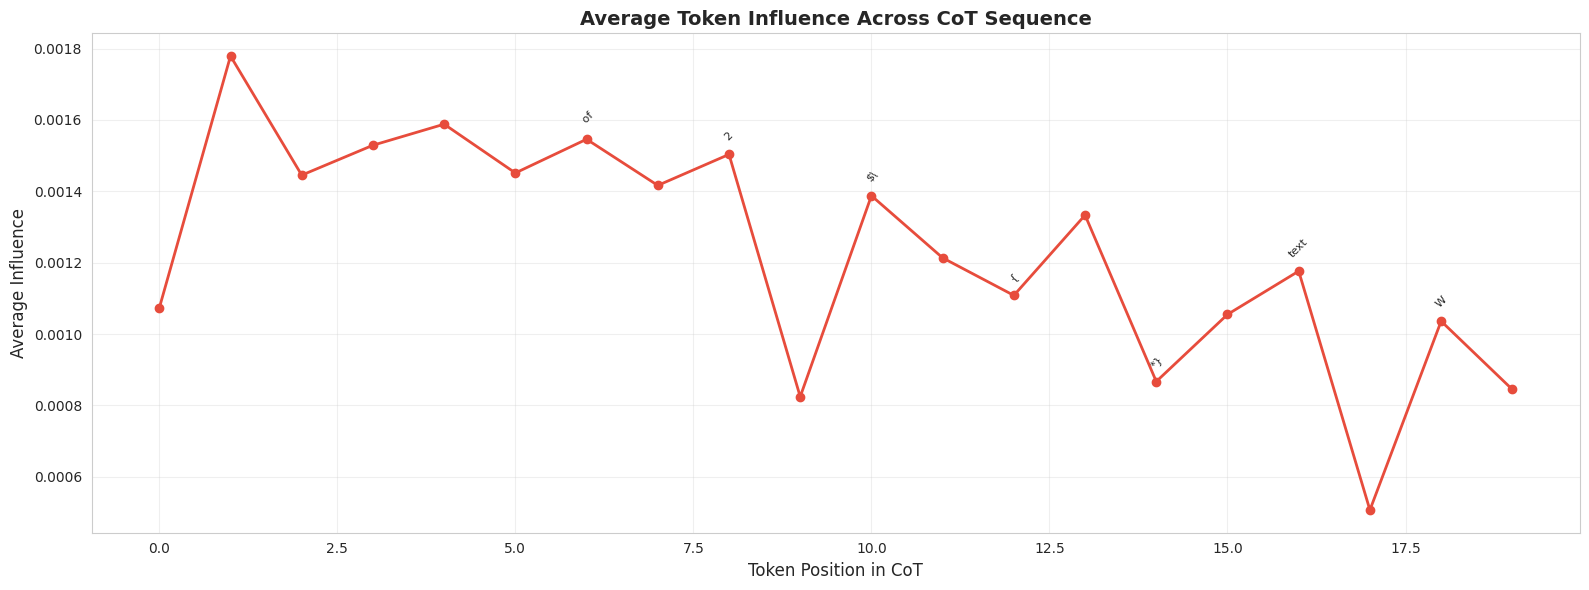

In [20]:
# Initialize analyzer
cot_analyzer = CoTHeatmapAnalyzer()

# Plot 1: Average influence over time
print("\n" + "="*60)
print("PLOT 1: Average Influence Over Time")
print("="*60)
cot_analyzer.plot_average_influence_over_time(
    heatmaps,
    save_path='./gsm8k_heatmaps/analysis_avg_influence.png'
)


PLOT 2: Layer Influence Evolution
✓ Saved to ./gsm8k_heatmaps/analysis_layer_evolution.png


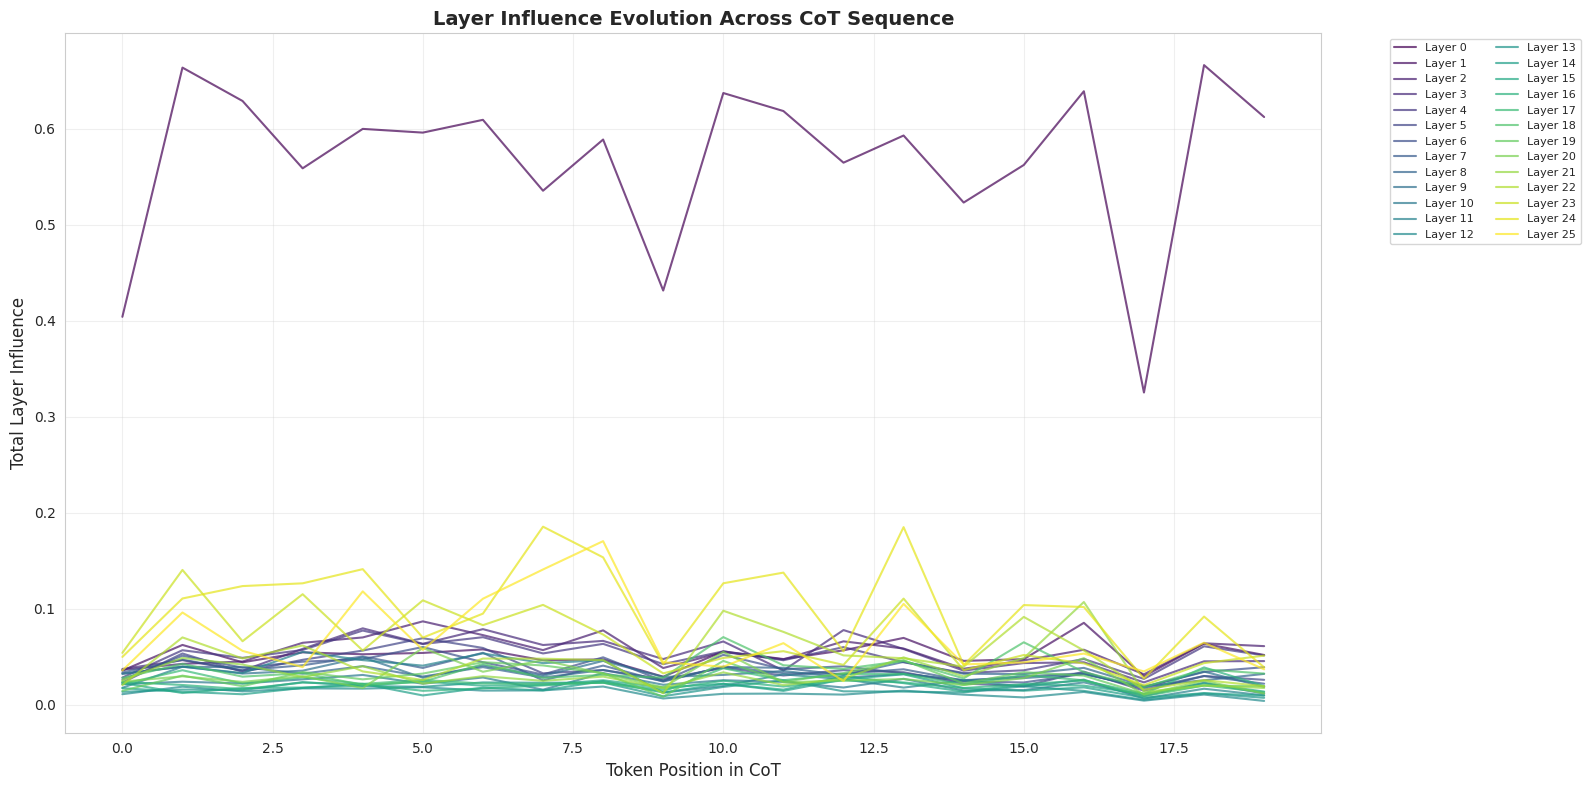

In [21]:
# Plot 2: Layer influence evolution
print("\n" + "="*60)
print("PLOT 2: Layer Influence Evolution")
print("="*60)
cot_analyzer.plot_layer_influence_evolution(
    heatmaps,
    save_path='./gsm8k_heatmaps/analysis_layer_evolution.png'
)


PLOT 3: Heatmap Grid (Sampled)
✓ Saved to ./gsm8k_heatmaps/analysis_heatmap_grid.png


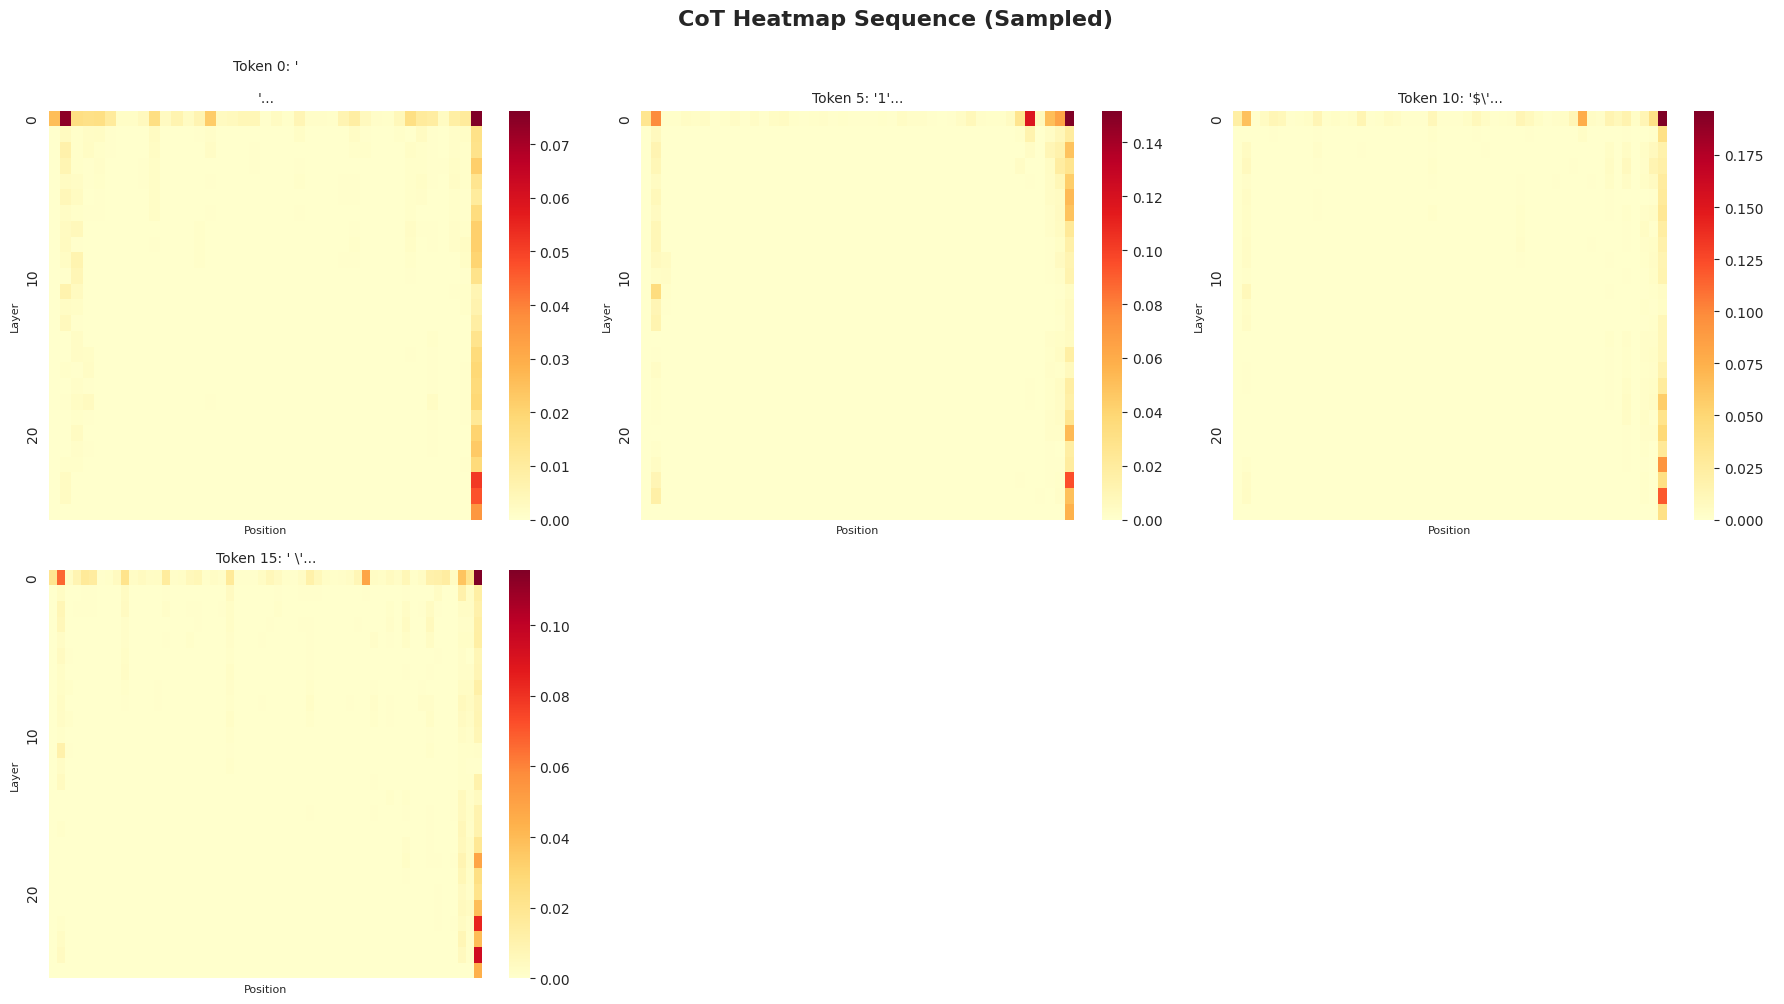

In [22]:
# Plot 3: Heatmap grid (sample every 5th token)
print("\n" + "="*60)
print("PLOT 3: Heatmap Grid (Sampled)")
print("="*60)
cot_analyzer.create_heatmap_grid(
    heatmaps,
    sample_every=5,
    save_path='./gsm8k_heatmaps/analysis_heatmap_grid.png'
)

In [23]:
# Generate summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

stats = cot_analyzer.generate_summary_statistics(heatmaps)

print(f"\nTotal tokens analyzed: {stats['n_tokens']}")
print(f"Overall average influence: {stats['overall_avg_influence']:.4f}")
print(f"Overall max influence: {stats['overall_max_influence']:.4f}")
print(f"\nMost influential layers (by frequency):")

from collections import Counter
layer_counts = Counter(stats['most_influential_layer_per_token'])
for layer, count in layer_counts.most_common(5):
    print(f"  Layer {layer}: {count} tokens ({count/stats['n_tokens']*100:.1f}%)")


SUMMARY STATISTICS

Total tokens analyzed: 20
Overall average influence: 0.0012
Overall max influence: 0.2112

Most influential layers (by frequency):
  Layer 0: 20 tokens (100.0%)


---
## Optional: View Individual Heatmaps

Display specific heatmaps from the sequence.

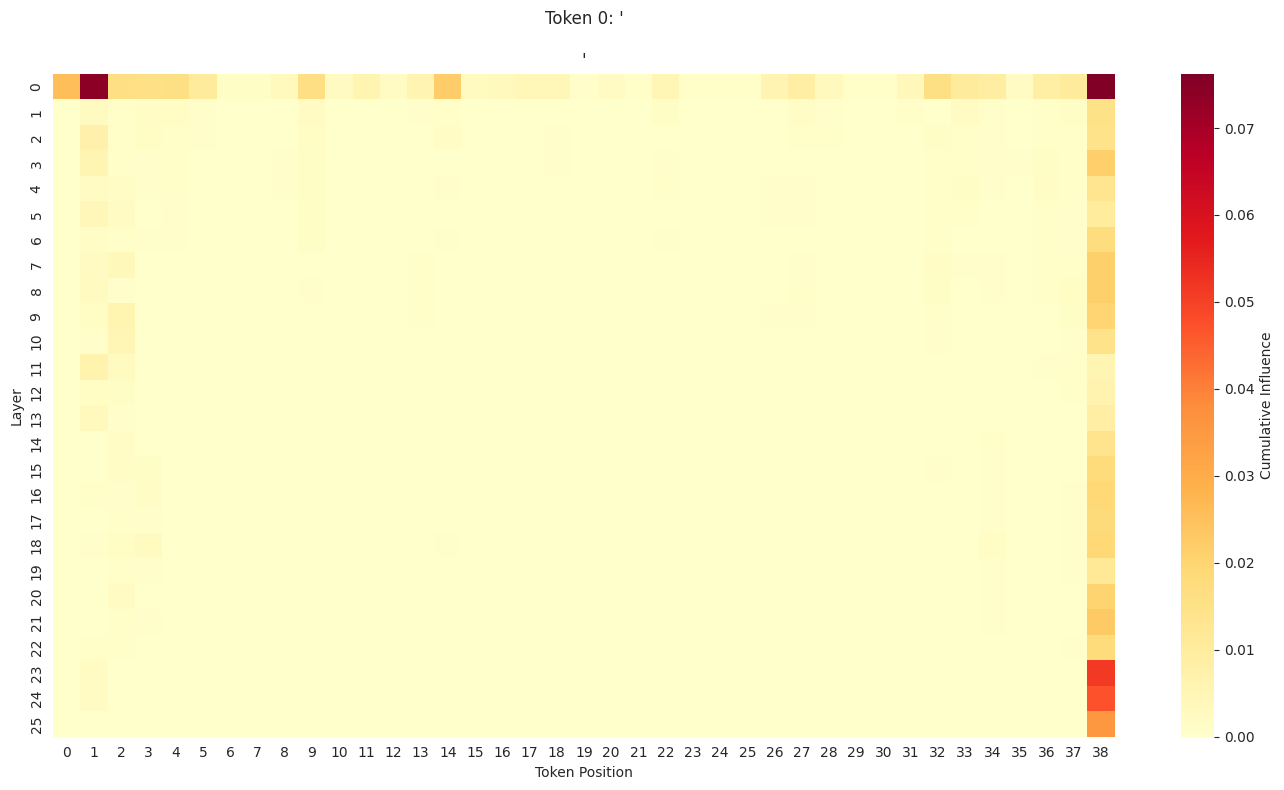

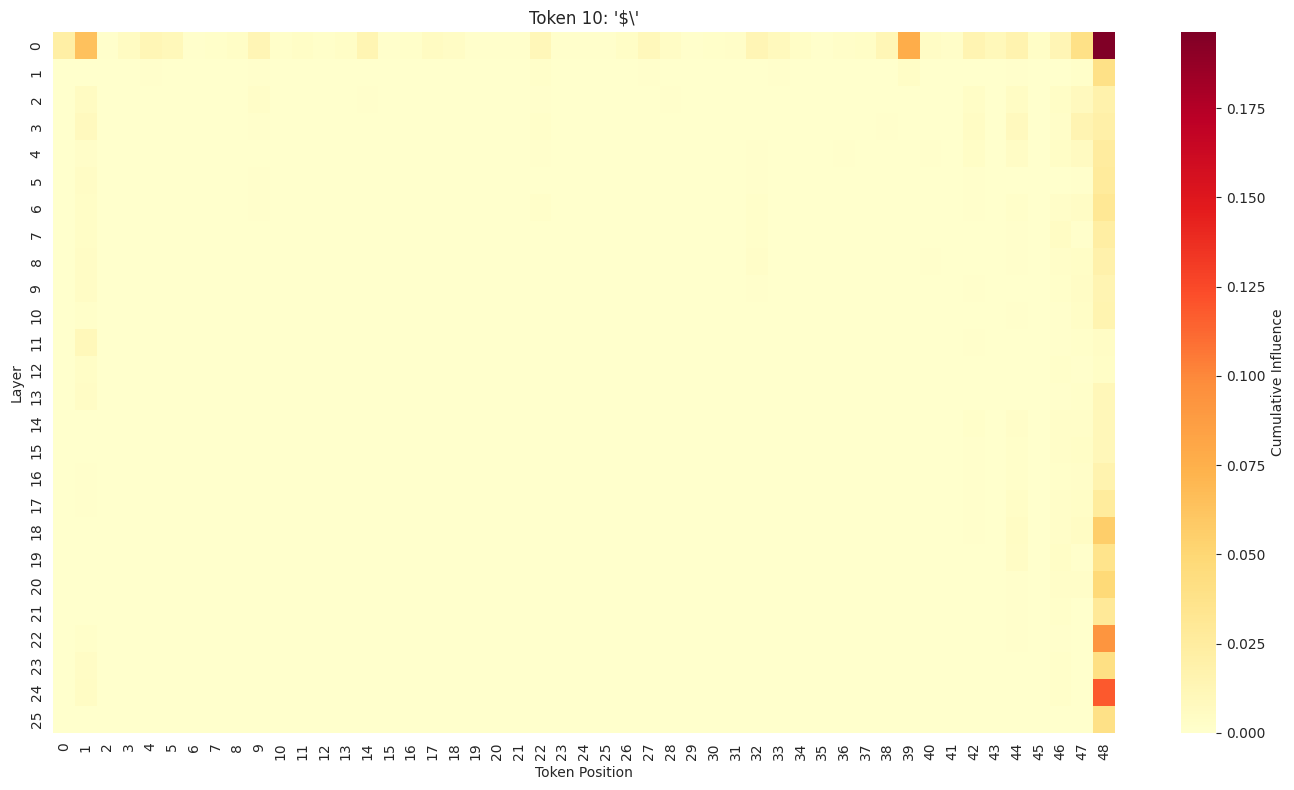

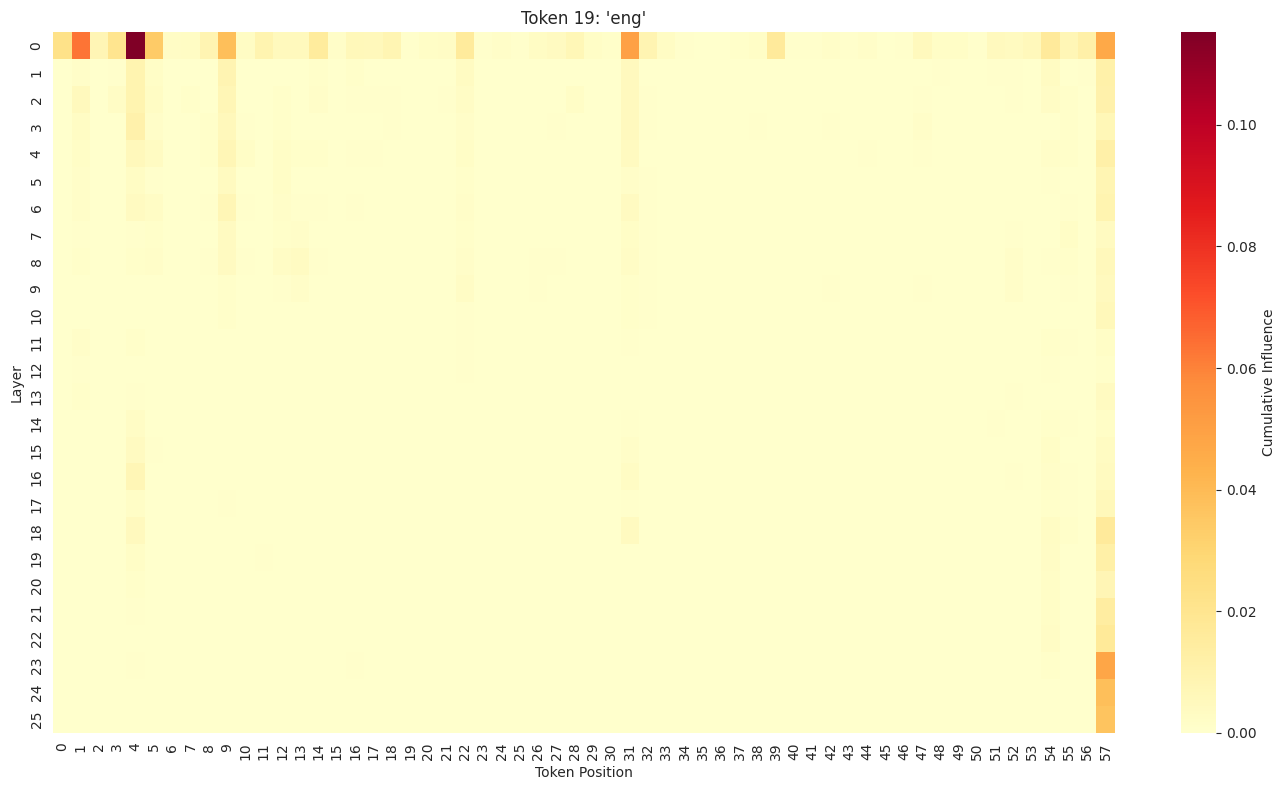

In [24]:
# View heatmaps at specific positions
positions_to_view = [0, 10, 20, -1]  # First, 10th, 20th, and last token

for pos in positions_to_view:
    if pos < len(heatmaps):
        hm = heatmaps[pos]

        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(
            hm['influence_matrix'],
            cmap='YlOrRd',
            ax=ax,
            cbar_kws={'label': 'Cumulative Influence'}
        )
        ax.set_title(f"Token {hm['token_idx']}: '{hm['token']}'")
        ax.set_xlabel('Token Position')
        ax.set_ylabel('Layer')
        plt.tight_layout()
        plt.show()

---
## Optional: Save Results for Later Analysis

In [ ]:
# Save graphs and heatmaps for later use
import pickle

output_data = {
    'prompt': prompt,
    'cot_response': cot_response,
    'graphs_data': graphs_data,
    'heatmaps': heatmaps,
    'statistics': stats
}

with open('./gsm8k_heatmaps/analysis_results.pkl', 'wb') as f:
    pickle.dump(output_data, f)

print("✓ Results saved to ./gsm8k_heatmaps/analysis_results.pkl")

---
## Next Steps

### For TNA-CPT Research:
1. **Node Tracking**: Implement cosine similarity matching to track features across graphs
2. **Temporal Unification**: Build unified graph spanning entire CoT sequence
3. **Persistence Analysis**: Identify features that remain active across multiple tokens
4. **Activation Patching**: Use `model.feature_intervention()` to test causal importance

### Analysis Ideas:
- Compare heatmaps for successful vs failed CoT runs
- Identify reasoning "transitions" where influence patterns change dramatically
- Track specific features across the sequence to find persistent reasoning circuits
- Compare GSM8K problems of different difficulty levels

### Scaling Up:
- Run on multiple GSM8K problems to find common patterns
- Scale to Gemma-2-9B or Llama-3.2-8B for better reasoning
- Use StrategyQA for different reasoning styles

---
## Troubleshooting

### Out of Memory (OOM) Errors:
```python
# Solution 1: Reduce feature nodes
graphs_data = analyzer.generate_sequential_graphs(
    prompt=prompt,
    cot_response=cot_response,
    max_feature_nodes=2048,  # Lower = less memory
    offload="cpu"  # Offload to CPU
)

# Solution 2: Process fewer tokens
short_cot = cot_response[:100]  # Only analyze first part
```

### Slow Performance:
```python
# Sample every Nth token instead of all tokens
full_tokens = model.tokenizer.encode(prompt + cot_response)
prompt_len = len(model.tokenizer.encode(prompt))

# Only analyze every 3rd token
for i in range(prompt_len, len(full_tokens), 3):
    # Generate graph for this token
    ...
```
